In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse

import astropy
from astropy.io import ascii
from astropy import units as u
from astropy.time import Time
import lightkurve as lk
from matplotlib.collections import LineCollection
from tqdm import tqdm_notebook as tqdm

import glob, os
from scripts import load_lightcurve

from astropy.table import Table, join, Column, unique, vstack
plt.rcParams['font.size'] = 20
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams['savefig.dpi']= 300             #72 
# mpl.rcParams["font.family"] = "Computer Modern Roman"
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.filterwarnings('ignore')


In [2]:
from matplotlib.colors import LinearSegmentedColormap
from pylab import *

cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula = LinearSegmentedColormap.from_list('parula', cm_data)

parula_colors = []
cmap = cm.get_cmap(parula, 2)
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    parula_colors.append(matplotlib.colors.rgb2hex(rgb))
parula_colors = np.array(parula_colors)

In [3]:
data = Table.read('joined_lofar.csv',format='ascii')
print(data.keys())

['Name', 'LOFAR Lum (x1E14 ergs/s/Hz)', 'Soft X-ray Lum (x1E28 ergs/s)', 'Uncert. Lofar Lum', 'Literature Rotation Period', 'Rotation Period', 'Flare Rate', 'N Flares', 'N Sectors', 'TIC']


In [4]:
lit, measured = data['Literature Rotation Period'],data['Rotation Period']

In [5]:
xray= np.array(data['Soft X-ray Lum (x1E28 ergs/s)'])
radio = np.array(data['LOFAR Lum (x1E14 ergs/s/Hz)'])
dradio = np.array(data['Uncert. Lofar Lum'])
flarerate = np.array(data['Flare Rate'])
names = np.array(data['Name'])

quiescent = ['GJ 625', 'GJ 450', 'GJ 1151', 'LP 169-22', 'G 240-45']
binaries = ['DG CVn', 'CR Dra', 'GJ 3861']

In [6]:
test = '2MASS J09481615+5114518'
def twomass_short(name):
    if '+' in name:
        a, b = name.split('+')
        return a[:-4].replace('2MASS','2M')+'+'+b[:4]
    else:
        return name

print([twomass_short(name) for name in data['Name']])

['CW UMa', 'LP 259-39', 'G 240-45', 'GJ 1151', 'WX Uma', 'GJ 450', 'GJ 3861', '2M J0948+5114', 'LP 212-62', 'DO Cep', 'GJ 625', 'DG CVn', 'CR Dra', 'LP 169-22', '2M J1433+3417']


In [7]:
paper_radio = Column((['$'+str(r)+' \pm '+str(dradio[j])+'$' for j,r  in enumerate(radio)]),name='LOFAR Lum.',
                    unit=r'($10^{14}$ erg/s/Hz)')
paper_xray = Column([r'$%s$' % xr for xr in xray],name='X-ray Lum.',unit=r'($10^{28}$ erg/s)')
paper_rot = []
for j, per in enumerate(lit):
    if lit.mask[j] or per == '?':
        paper_rot.append(r'%.2g$^\dagger$' % float(measured[j]))
    else:
        paper_rot.append(r'%.2g' % float(per))
paper_rot = Column(paper_rot,name='Rotation Period',unit=r'(d$^{-1}$)')
paper_flare = Column([float('%.3g' % frate) for frate in flarerate],name='Flare Rate',unit=r'(d$^{-1}$)')
paper_name = Column([twomass_short(name) for name in names], name='Name')

paper_table = Table([paper_name,data['TIC'],paper_xray,paper_radio,paper_flare,paper_rot])
paper_table.sort('Flare Rate')
caption = r'Properties of LOFAR radio M dwarfs observed by TESS. Asterisks denote stars observed simultaneously by LOFAR and TESS.'
caption += r' Rotation periods are from literature, except those denoted by daggers, which are from these TESS observations.'
caption += r' \label{table:papertable}'


ascii.write(paper_table, 'paper_table.tex', Writer = ascii.AASTex,
            latexdict = {'tabletype': 'deluxetable','caption':caption})


In [8]:
uplims = ['<' in xr for xr in xray]
xrayclean = [float((xr).strip('<')) for xr in xray]

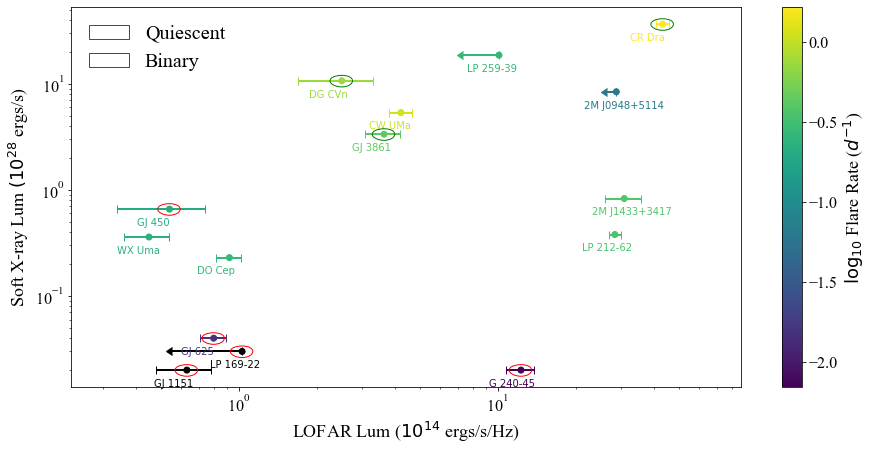

In [9]:
fig = plt.figure(figsize=(15.0,7.0))
ax = plt.gca()

this_mappable = np.log10((flarerate))
bad = ~np.isfinite(this_mappable)
this_mappable[bad] = np.nan

vmin,vmax = np.nanmin(this_mappable),np.nanmax(this_mappable)
this_mappable[bad] = -10

thismap = mpl.cm.viridis
thismap.set_bad(color='k')

sc = plt.scatter(radio,xrayclean,c=this_mappable,cmap=thismap)
sc.cmap.set_under('k')
sc.set_clim(vmin, vmax)

#create colorbar according to the scatter plot
clb = plt.colorbar(sc)
clb.set_label(r'$\log_{10}$ Flare Rate ($d^{-1}$)',fontsize=18)
clb.ax.tick_params(labelsize=16) 

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=thismap)
this_mappable[bad] = np.nan
color = np.array([(mapper.to_rgba(v)) for v in this_mappable])

for j in range(15):
    plt.errorbar(radio[j],xrayclean[j],xerr=dradio[j],xuplims=uplims[j],ls='None',c=color[j], lw=2, capsize=4)
plt.xscale('log')
plt.yscale('log')
plt.xlim(np.min(radio)*0.5,np.max(radio)*2)
plt.xlabel('LOFAR Lum ($10^{14}$ ergs/s/Hz)',fontsize=18)
plt.ylabel(r'Soft X-ray Lum $(10^{28}$ ergs/s)',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


for j, star in enumerate(names):
    wh = np.where(names==star)[0][0]
    plt.text(radio[wh]*0.75,xrayclean[wh]*0.7,twomass_short(star),fontsize=10,c=color[j],fontname='DejaVu Sans')
# fig.colorbar(mpl.cm.ScalarMappable(norm=None,cmap=mpl.cm.hot(flarerate)))

for j, star in enumerate(quiescent):
    wh = np.where(names==star)[0][0]
    xy = (radio[wh],xrayclean[wh])
    f = Ellipse(xy=xy,width=radio[wh]/5.,height=xrayclean[wh]/4.,angle=0,fc='None',edgecolor='r',zorder=11,
               transform=ax.transData)
    fig.add_artist(f)

    
for j, star in enumerate(binaries):
    wh = np.where(names==star)[0][0]
    xy = (radio[wh],xrayclean[wh])
    g = Ellipse(xy=xy,width=radio[wh]/5.,height=xrayclean[wh]/4.,angle=0,fc='None',edgecolor='g',zorder=11,
               transform=ax.transData)
    fig.add_artist(g)

plt.legend([f,g],['Quiescent','Binary'],frameon=False)
plt.savefig('gudel_benz_flares.png',bbox_inches='tight')
plt.savefig('gudel_benz_flares.pdf',bbox_inches='tight')

In [10]:
gudel_m_dwarfs = Table.read('../data/m_dwarfs_gudel2002.csv',format='ascii')
gudel_k_dwarfs = Table.read('../data/k_dwarfs_gudel2002.csv',format='ascii')
gudel_fk_com = Table.read('../data/fk_com_gudel2002.csv',format='ascii')
gudel_rs_cvns = Table.read('../data/rs_cvns_gudel2002.csv',format='ascii')
gudel_by_dra = Table.read('../data/by_dra_gudel2002.csv',format='ascii')

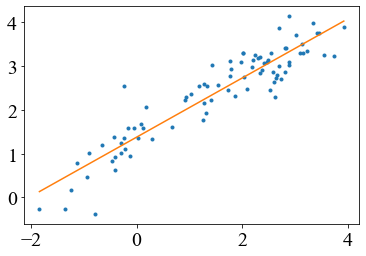

In [11]:
xx = np.concatenate([gudel_m_dwarfs['col1']/1.0e14, 
                     gudel_k_dwarfs['col1']/1.0e14,
                     gudel_fk_com['col1']/1.0e14,
                     gudel_rs_cvns['col1']/1.0e14,
                     gudel_by_dra['col1']/1.0e14])
xx = np.log10(xx)

yy = np.concatenate([gudel_m_dwarfs['col2']/1.0e28, 
                     gudel_k_dwarfs['col2']/1.0e28,
                     gudel_fk_com['col2']/1.0e28,
                     gudel_rs_cvns['col2']/1.0e28,
                     gudel_by_dra['col2']/1.0e28])
yy = np.log10(yy)
coef = np.polyfit(xx,yy,1)
poly1d_fn = np.poly1d(coef) 


xxx = np.linspace(xx.min(),xx.max(),1000)
plt.plot(xx,yy,'.')
plt.plot(xxx,poly1d_fn(xxx))


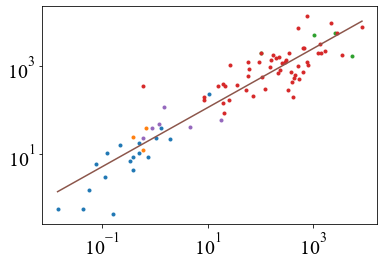

In [12]:
plt.plot(gudel_m_dwarfs['col1']/1.0e14,gudel_m_dwarfs['col2']/1.0e28,'.')
plt.plot(gudel_k_dwarfs['col1']/1.0e14,gudel_k_dwarfs['col2']/1.0e28,'.')
plt.plot(gudel_fk_com['col1']/1.0e14,gudel_fk_com['col2']/1.0e28,'.')

plt.plot(gudel_rs_cvns['col1']/1.0e14,gudel_rs_cvns['col2']/1.0e28,'.')
plt.plot(gudel_by_dra['col1']/1.0e14,gudel_by_dra['col2']/1.0e28,'.')

plt.plot(10**xxx,10**poly1d_fn(xxx))
plt.xscale('log')
plt.yscale('log')

In [13]:
def short_2mass(name):
    if '2MASS' in name:
        name = name.split('+')[0][:-4]+'+'+name.split('+')[1][:4]
        name.replace('2MASS','2M')
    return name

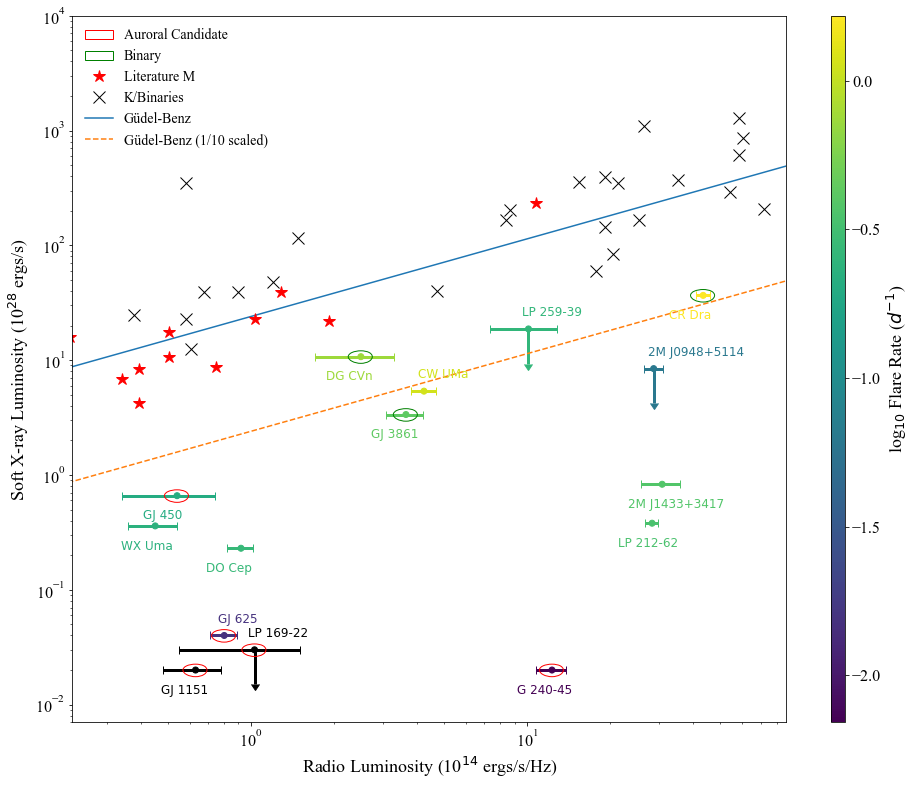

In [45]:
fig = plt.figure(figsize=(16.0,13.))
ax = plt.gca()

this_mappable = np.log10((flarerate))
bad = ~np.isfinite(this_mappable)
this_mappable[bad] = np.nan

vmin,vmax = np.nanmin(this_mappable),np.nanmax(this_mappable)
this_mappable[bad] = -10

thismap = mpl.cm.viridis
thismap.set_bad(color='k')

sc = plt.scatter(radio,xrayclean,c=this_mappable,cmap=thismap)
sc.cmap.set_under('k')
sc.set_clim(vmin, vmax)

#create colorbar according to the scatter plot
clb = plt.colorbar(sc,aspect=50)
clb.set_label(r'log$_{10}$ Flare Rate ($d^{-1}$)',fontsize=18)
clb.ax.tick_params(labelsize=16) 

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=thismap)
this_mappable[bad] = np.nan
color = np.array([(mapper.to_rgba(v)) for v in this_mappable])

for j in range(15):
    if uplims[j]:    
        plt.errorbar(radio[j],xrayclean[j],xerr=dradio[j],uplims=uplims[j],yerr=xrayclean[j]/2.,
                     ls='None',c=color[j], lw=3, capsize=4)
    else:
        plt.errorbar(radio[j],xrayclean[j],xerr=dradio[j],
                     ls='None',c=color[j], lw=3, capsize=4)
plt.xscale('log')
plt.yscale('log')
plt.xlim(np.min(radio)*0.5,np.max(radio)*2)
plt.xlabel('Radio Luminosity (10$^{14}$ ergs/s/Hz)',fontsize=18)
plt.ylabel(r'Soft X-ray Luminosity (10$^{28}$ ergs/s)',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


for j, star in enumerate(names):
    if ((star in ['LP 169-22','GJ 625','LP 259-39','CW UMa']) or uplims[j]):
        wh = np.where(names==star)[0][0]
        plt.text(radio[wh]*0.95,xrayclean[wh]*1.3,twomass_short(star),fontsize=12,c=color[j],fontname='DejaVu Sans')
    else:
        wh = np.where(names==star)[0][0]
        plt.text(radio[wh]*0.75,xrayclean[wh]*0.625,twomass_short(star),fontsize=12,c=color[j],fontname='DejaVu Sans')
# fig.colorbar(mpl.cm.ScalarMappable(norm=None,cmap=mpl.cm.hot(flarerate)))

for j, star in enumerate(quiescent):
    wh = np.where(names==star)[0][0]
    xy = (radio[wh],xrayclean[wh])
    f = Ellipse(xy=xy,width=radio[wh]/5.,height=xrayclean[wh]/4.,angle=0,fc='None',edgecolor='r',zorder=11,
               transform=ax.transData)
    fig.add_artist(f)

    
for j, star in enumerate(binaries):
    wh = np.where(names==star)[0][0]
    xy = (radio[wh],xrayclean[wh])
    g = Ellipse(xy=xy,width=radio[wh]/5.,height=xrayclean[wh]/4.,angle=0,fc='None',edgecolor='g',zorder=11,
               transform=ax.transData)
    fig.add_artist(g)

markersize = 12
trend = plt.plot(10**xxx,10**poly1d_fn(xxx),label='Güdel-Benz') # trend line
ourtrend = plt.plot(10**xxx,0.1*10**poly1d_fn(xxx),label='Güdel-Benz',linestyle='--') # trend line / 10
mm = plt.plot(gudel_m_dwarfs['col1']/1.0e14,gudel_m_dwarfs['col2']/1.0e28,'*r',markersize=markersize)
kk = plt.plot(gudel_k_dwarfs['col1']/1.0e14,gudel_k_dwarfs['col2']/1.0e28,'xk',markersize=markersize)
plt.plot(gudel_fk_com['col1']/1.0e14,gudel_fk_com['col2']/1.0e28,'xk',markersize=markersize)

plt.plot(gudel_rs_cvns['col1']/1.0e14,gudel_rs_cvns['col2']/1.0e28,'xk',markersize=markersize)
plt.plot(gudel_by_dra['col1']/1.0e14,gudel_by_dra['col2']/1.0e28,'xk',markersize=markersize)

# plt.legend([f,g,mm[0],kk[0]],['Quiescent','Binary','Literature M','K/Binaries'],frameon=False,loc=2)
plt.legend([f,g,mm[0],kk[0],trend[0],ourtrend[0]],
           ['Auroral Candidate','Binary','Literature M','K/Binaries','Güdel-Benz','Güdel-Benz (1/10 scaled)'],
           framealpha=1,edgecolor='white',loc=2,fontsize=14)

plt.ylim(0.7e-2,1e4)

plt.savefig('gudel_benz_flares_context.png',bbox_inches='tight')
plt.savefig('gudel_benz_flares_context.pdf',bbox_inches='tight')

In [15]:
lp169 = data[data['Name']=='LP 169-22']#['Soft X-ray Lum (x1E28 ergs/s)']
this_lum = float(lp169['Soft X-ray Lum (x1E28 ergs/s)'][0].strip('<'))
this_dr = float(lp169['Uncert. Lofar Lum'][0])
this_r = float(lp169['LOFAR Lum (x1E14 ergs/s/Hz)'][0])
print(this_r,this_dr,this_lum)

1.03 0.48 0.03


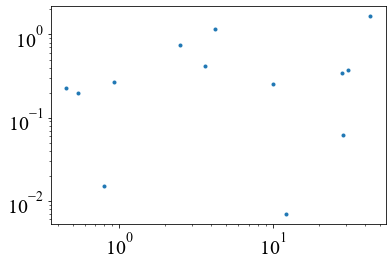

In [16]:
plt.plot(radio,flarerate,'.')
plt.xscale('log')
plt.yscale('log')

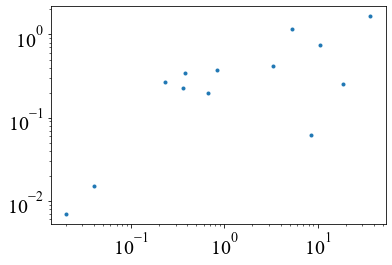

In [17]:
plt.plot(xrayclean,flarerate,'.')
plt.xscale('log')
plt.yscale('log')

In [18]:
tics, time, flux, errs, sects, all_lcs = load_lightcurve(star)

Loaded from saved files ['../data/lcs/gj_3861_s0015_lc.fits', '../data/lcs/gj_3861_s0016_lc.fits', '../data/lcs/gj_3861_s0023_lc.fits']


In [19]:
all_lcs = []
all_preds = []
ddir = '../results/final/'
for star in quiescent:
    print('Doing %s' % star)
    try:
        tics, time, flux, errs, sects, lcs = load_lightcurve(star)
        lcs = lcs[0]
    except:
        tic = data['TIC'][np.where(data['Name']==star)]
        search = lk.search_lightcurvefile('TIC %d' % tic,exptime=120) # why is the TIC wrong?
        print(search)
        lcs = search[0].download().PDCSAP_FLUX.normalize().remove_nans()#.download_all().stitch()
    all_lcs.append(lcs)
    avg_preds = []
    for j in range(len(sects)):
        avg_preds.append(Table.read('%savg_preds_%s_%d.csv' % (ddir,star.replace(' ','_').lower(), j))['avg_preds'].data)
    avg_preds = np.array(avg_preds)
    all_preds.append(avg_preds[0])

Doing GJ 625
Loaded from saved files ['../data/lcs/gj_625_s0016_lc.fits', '../data/lcs/gj_625_s0023_lc.fits', '../data/lcs/gj_625_s0025_lc.fits']
Doing GJ 450
Loaded from saved files ['../data/lcs/gj_450_s0022_lc.fits']
Doing GJ 1151
Loaded from saved files ['../data/lcs/gj_1151_s0022_lc.fits']
Doing LP 169-22
Loaded from saved files ['../data/lcs/lp_169-22_s0021_lc.fits', '../data/lcs/lp_169-22_s0022_lc.fits']
Doing G 240-45
Loaded from saved files ['../data/lcs/g_240-45_s0014_lc.fits', '../data/lcs/g_240-45_s0015_lc.fits', '../data/lcs/g_240-45_s0016_lc.fits', '../data/lcs/g_240-45_s0017_lc.fits', '../data/lcs/g_240-45_s0018_lc.fits', '../data/lcs/g_240-45_s0019_lc.fits', '../data/lcs/g_240-45_s0021_lc.fits', '../data/lcs/g_240-45_s0022_lc.fits', '../data/lcs/g_240-45_s0024_lc.fits', '../data/lcs/g_240-45_s0025_lc.fits', '../data/lcs/g_240-45_s0026_lc.fits']


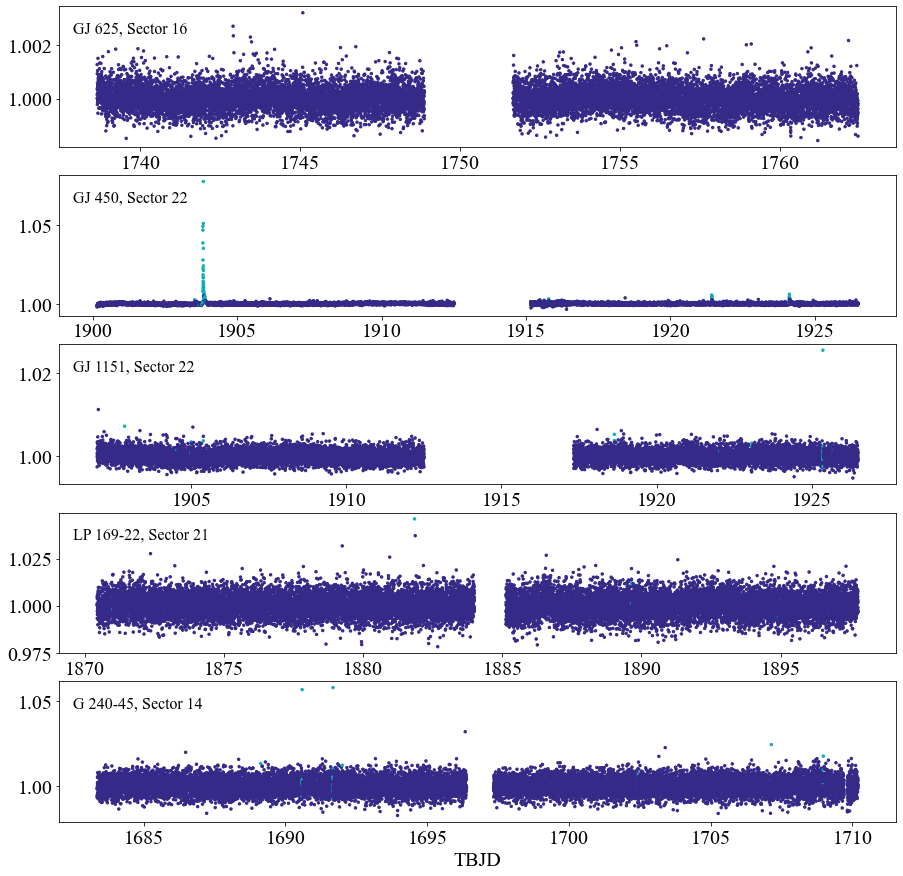

In [20]:
fig, axes = plt.subplots(5,1,figsize=(15,15))
for j, lc in enumerate(all_lcs):
    c=np.ones(len(all_preds[j]), dtype='U10')
    c[all_preds[j] < 0.6] = parula_colors[0]
    c[all_preds[j] >=0.6] = parula_colors[110]

    ax = axes[j]
    ax.set_rasterized(True)
    ax.scatter(lc.time.value,lc.flux,c=c,label='%s, Sector %d' % (quiescent[j],lc.sector),
               vmin=0, vmax=1, s=6, cmap=parula.reversed())
    leg = ax.legend(frameon=False,loc=2,handlelength=0, handletextpad=0,fontsize=16)
    for item in leg.legendHandles:
        item.set_visible(False)
#     ax.set_ylim(0.98,1.055)
    if j == 4:
        ax.set_xlabel('TBJD')
        
plt.savefig('quiescent_stars_1_sector.png',bbox_inches='tight',rasterized=True)
plt.savefig('quiescent_stars_1_sector.pdf',bbox_inches='tight',rasterized=True)

In [21]:
all_lcs = []
all_preds = []

active = [x for x in list(data['Name']) if x not in quiescent]
# active = [x for x in active if x not in ['DO Cep']]

for star in active:
    print('Doing %s' % star)
    try:
        tics, time, flux, errs, sects, lcs = load_lightcurve(star)
        lcs = lcs[0]
    except:
        tic = data['TIC'][np.where(data['Name']==star)]
        search = lk.search_lightcurvefile('TIC %d' % tic,exptime=120) # why is the TIC wrong?
        print(search)
        lcs = search[0].download().PDCSAP_FLUX.normalize().remove_nans()#.download_all().stitch()
    all_lcs.append(lcs)
    avg_preds = []
    for j in range(len(sects)):
        avg_preds.append(Table.read('%savg_preds_%s_%d.csv' % (ddir,star.replace(' ','_').lower(), j))['avg_preds'].data)
    avg_preds = np.array(avg_preds)
    all_preds.append(avg_preds[0])

Doing CW UMa
Loaded from saved files ['../data/lcs/cw_uma_s0022_lc.fits']
Doing LP 259-39
Loaded from saved files ['../data/lcs/lp_259-39_s0021_lc.fits']
Doing WX Uma
Loaded from saved files ['../data/lcs/wx_uma_s0021_lc.fits']
Doing GJ 3861
Loaded from saved files ['../data/lcs/gj_3861_s0015_lc.fits', '../data/lcs/gj_3861_s0016_lc.fits', '../data/lcs/gj_3861_s0023_lc.fits']
Doing 2MASS J09481615+5114518
Loaded from saved files ['../data/lcs/2mass_j09481615+5114518_s0021_lc.fits']
Doing LP 212-62
Loaded from saved files ['../data/lcs/lp_212-62_s0021_lc.fits']
Doing DO Cep
Loaded from saved files ['../data/lcs/do_cep_s0016_lc.fits', '../data/lcs/do_cep_s0017_lc.fits', '../data/lcs/do_cep_s0024_lc.fits']
Doing DG CVn
Loaded from saved files ['../data/lcs/dg_cvn_s0023_lc.fits']
Doing CR Dra
Loaded from saved files ['../data/lcs/cr_dra_s0016_lc.fits', '../data/lcs/cr_dra_s0023_lc.fits', '../data/lcs/cr_dra_s0024_lc.fits', '../data/lcs/cr_dra_s0025_lc.fits']
Doing 2MASS J14333139+3417472
Lo

In [22]:
wx_uma_tpf = lk.search_targetpixelfile('TIC 252803603',exptime=120).download()
corrector = lk.TessPLDCorrector(wx_uma_tpf)
wx_uma_lc = corrector.correct().remove_nans().normalize()

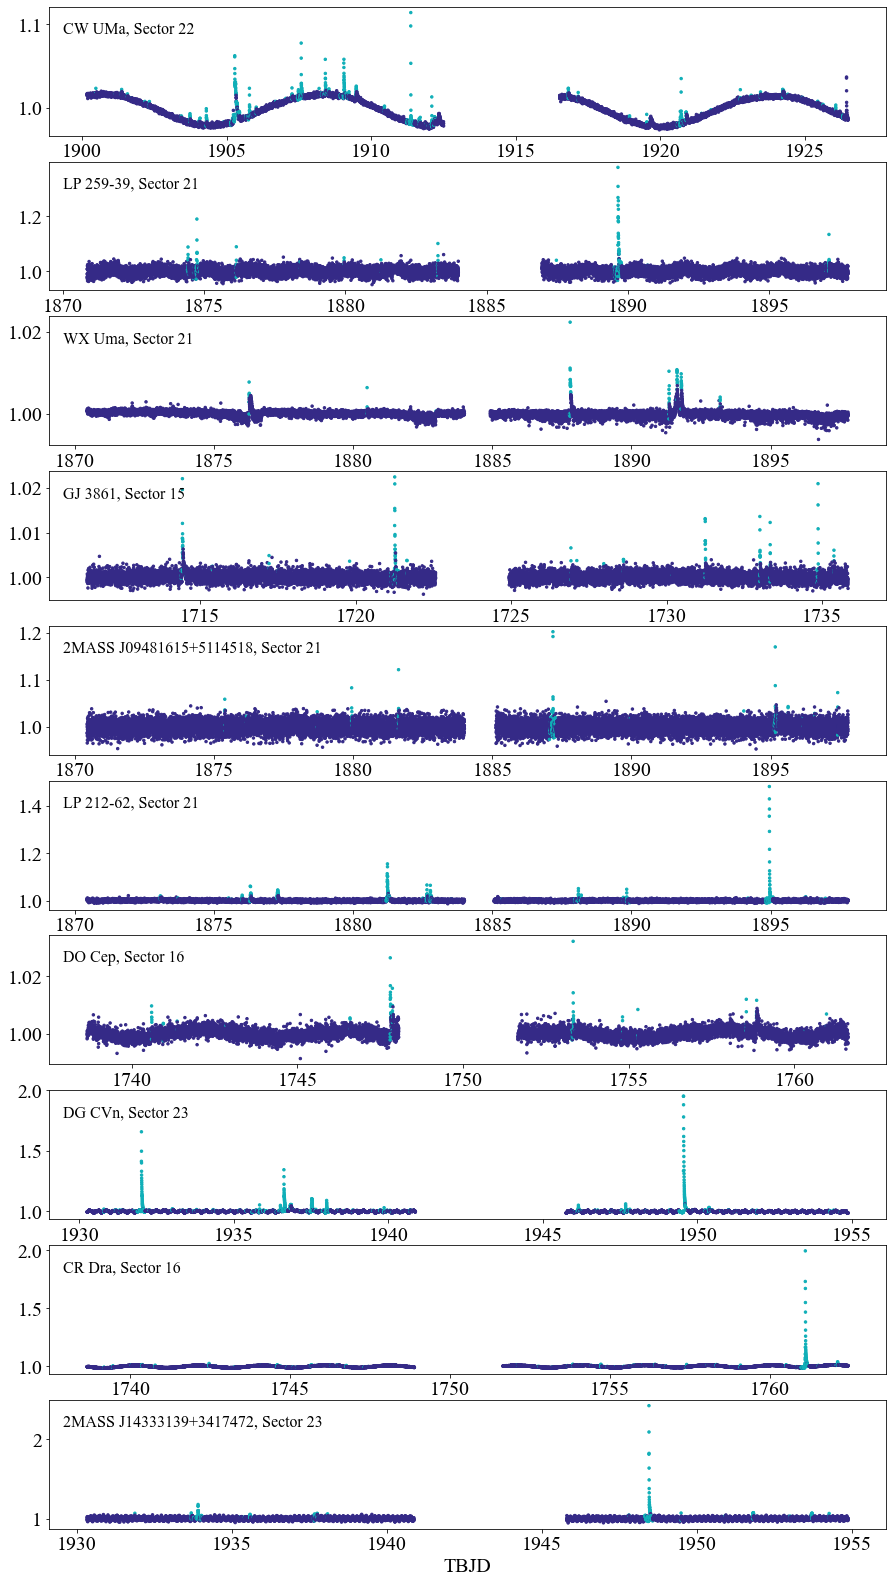

In [23]:
fig, axes = plt.subplots(10,1,figsize=(15,28))
plt.rcParams['font.size'] = 18

for j, lc in enumerate(all_lcs):
    c=np.ones(len(all_preds[j]), dtype='U10')
    c[all_preds[j] < 0.6] = parula_colors[0]
    c[all_preds[j] >=0.6] = parula_colors[110]

    lcc = lc.remove_nans()
    ax = axes[j]
    ax.set_rasterized(True)
    ax.scatter(lcc.time.value,lcc.flux,c=c,label='%s, Sector %d' % (active[j],lcc.sector),
               vmin=0, vmax=1, s=6, cmap=parula.reversed())
    leg = ax.legend(frameon=False,loc=2,handlelength=0, handletextpad=0,fontsize=16)
    for item in leg.legendHandles:
        item.set_visible(False)

#         ax.set_ylim(0.93,1.1)
    if j == 9:
        ax.set_xlabel('TBJD')
#     except:
#         lcc = lc.remove_nans()
#         ax = axes[j]
#         ax.set_rasterized(True)
#         ax.plot(lcc.time.value,lcc.flux,'.k',label='%s, Sector %d' % (active[j],lcc.sector),markersize=6)
#         leg = ax.legend(frameon=False,loc=2,fontsize=16)
# #         ax.set_ylim(0.93,1.1)
#         if j == 9:
#             ax.set_xlabel('TBJD')

plt.savefig('active_stars_1_sector.png',bbox_inches='tight',rasterized=True)
plt.savefig('active_stars_1_sector.pdf',bbox_inches='tight',rasterized=True)

## Now let's do the simultaneous ones

In [24]:
stars_simultaneous = {'GJ 450':'2020-03-16T20:11:00',
         '2MASS J09481615+5114518':'2020-01-31T20:45:40'}
simultaneous = stars_simultaneous.keys()

all_lcs = []
all_preds = []

for star in simultaneous:
    print('Doing %s' % star)
    tic = data['TIC'][np.where(data['Name']==star)]
    try:
        tics, time, flux, errs, sects, lcs = load_lightcurve(star)
        lcs = lcs[0]
    except:
        tic = data['TIC'][np.where(data['Name']==star)]
        search = lk.search_lightcurvefile('TIC %d' % tic,exptime=120) # why is the TIC wrong?
        print(search)
        lcs = search[0].download().PDCSAP_FLUX.normalize().remove_nans()#.download_all().stitch()
    all_lcs.append(lcs)
    avg_preds = []
    for j in range(len(sects)):
        avg_preds.append(Table.read('%savg_preds_%s_%d.csv' % (ddir,star.replace(' ','_').lower(), j))['avg_preds'].data)
    avg_preds = np.array(avg_preds)
    all_preds.append(avg_preds[0])

Doing GJ 450
Loaded from saved files ['../data/lcs/gj_450_s0022_lc.fits']
Doing 2MASS J09481615+5114518
Loaded from saved files ['../data/lcs/2mass_j09481615+5114518_s0021_lc.fits']


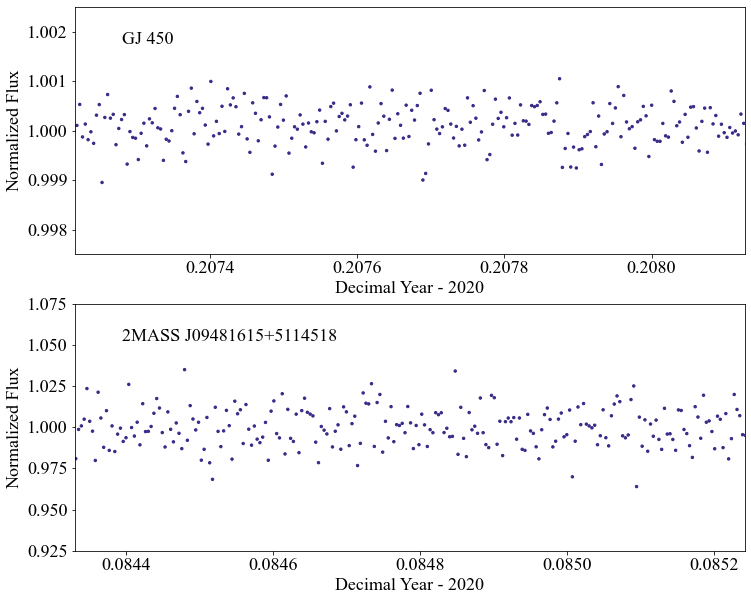

In [25]:
fig, axes = plt.subplots(2,1,figsize=(12.0,10.0))
from astropy.time import Time, TimeDelta

for j, star in enumerate(simultaneous):
    ax = axes[j]
    ax.set_rasterized(True)
    lc = all_lcs[j]
    tstart = stars_simultaneous[star]
    dates = lc.time
    t = Time(tstart, format='isot', scale='utc')
    dt = TimeDelta(3600.*8., format='sec')
    tfinish = t+dt
    
    c=np.ones(len(all_preds[j]), dtype='U10')
    c[all_preds[j] < 0.6] = parula_colors[0]
    c[all_preds[j] >=0.6] = parula_colors[110]

    ax.scatter(dates.decimalyear-2020,lc.flux,c=np.hstack(c),
                        vmin=0, vmax=1, s=6, label=star, cmap=parula.reversed())
    ax.set_xlim(t.decimalyear-2020,tfinish.decimalyear-2020)
#     ax.axvline(t.decimalyear-2020)
#     ax.axvline(tfinish.decimalyear-2020)

    ax.set_xlabel('Decimal Year - 2020')
    ax.set_ylabel('Normalized Flux')
#     leg = ax.legend(frameon=False,loc=2,handlelength=0, handletextpad=0,fontsize=16)
    ax.annotate(star,xy=(0.07,0.85),xycoords='axes fraction' )
    # plt.ylim(0.98,1.01)
    # plt.xlim(t.decimalyear-2020-0.05,tfinish.decimalyear-2020+0.05)
#     a.colorbar()

axes[0].set_ylim(0.9975,1.0025)
axes[1].set_ylim(0.925,1.075)

plt.savefig('simultaneous_obs.png',bbox_inches='tight',rasterized=True)
plt.savefig('simultaneous_obs.pdf',bbox_inches='tight',rasterized=True)

## Now let's look at the overall flare-rate distribution using the Günther data.

In [26]:
gunther = Table.read('../data/combined_catalog_per_star.csv')
gunther.rename_column('TIC_ID','TIC')

In [27]:
data['TIC']

85334035
166597074
307957392
11893637
252803603
144400022
298164374
453430899
392365135
414587194
207492082


In [28]:
joined = join(gunther,data,keys='TIC')
joined.sort('Name')
print(joined['Name','TIC'])

          Name             TIC   
----------------------- ---------
2MASS J09481615+5114518 453430899
                 CR Dra 207436278
                 CW UMa  85334035
                 DO Cep 414587194
               G 240-45 307957392
                GJ 1151  11893637
                GJ 3861 298164374
                 GJ 450 144400022
                 GJ 625 207492082
              LP 169-22 148673115
              LP 212-62 392365135
              LP 259-39 166597074
                 WX Uma 252803603


In [29]:
data.sort('Name')
print(data)

          Name          LOFAR Lum (x1E14 ergs/s/Hz) ... N Sectors    TIC   
----------------------- --------------------------- ... --------- ---------
2MASS J09481615+5114518                       28.71 ...         1 453430899
2MASS J14333139+3417472                       30.82 ...         1 409372963
                 CR Dra                       43.38 ...         4 207436278
                 CW UMa                        4.23 ...         1  85334035
                 DG CVn                         2.5 ...         1 368129164
                 DO Cep                        0.92 ...         3 414587194
               G 240-45                        12.3 ...        11 307957392
                GJ 1151                        0.63 ...         1  11893637
                GJ 3861                        3.64 ...         3 298164374
                 GJ 450                        0.54 ...         1 144400022
                 GJ 625                         0.8 ...         3 207492082
            

In [30]:
# 2MASS J14333139+3417472 and DG CVn missing from Gunther?

In [31]:
gunther.sort('TIC')

In [32]:
# rm /Users/benjaminpope/.astropy/cache/astroquery/Simbad/*


In [33]:
data.keys()

['Name',
 'LOFAR Lum (x1E14 ergs/s/Hz)',
 'Soft X-ray Lum (x1E28 ergs/s)',
 'Uncert. Lofar Lum',
 'Literature Rotation Period',
 'Rotation Period',
 'Flare Rate',
 'N Flares',
 'N Sectors',
 'TIC']

In [34]:
print(joined.keys())

['TIC', 'OBS_Sector', 'TICv8_ra', 'TICv8_dec', 'TICv8_Teff', 'TICv8_Tmag', 'TICv8_d', 'BANYAN_BEST_HYP', 'N_flares', 'N_flares_per_day', 'flare_amp_max', 'flare_amp_median', 'flare_dur_max', 'flare_dur_median', 'flare_prob_max', 'flare_prob_median', 'Name', 'LOFAR Lum (x1E14 ergs/s/Hz)', 'Soft X-ray Lum (x1E28 ergs/s)', 'Uncert. Lofar Lum', 'Literature Rotation Period', 'Rotation Period', 'Flare Rate', 'N Flares', 'N Sectors']


In [35]:
joined['Name','N Flares', 'N_flares', 'Flare Rate','N_flares_per_day'] # with underscore is Gunther

Name,N Flares,N_flares,Flare Rate,N_flares_per_day
str23,int64,int64,float64,float64
2MASS J09481615+5114518,2,9,0.062645,0.32727272727272727
CR Dra,152,253,1.653901,2.3
CW UMa,26,51,1.14904,1.8545454545454545
DO Cep,18,44,0.270382,0.5333333333333333
G 240-45,2,31,0.006941,0.1024793388429752
GJ 1151,0,3,0.0,0.10909090909090909
GJ 3861,27,46,0.423265,0.5575757575757576
GJ 450,5,5,0.199402,0.18181818181818182
GJ 625,1,2,0.015187,0.024242424242424242


## Now let's look at Tara Murphy's stars

In [36]:
from scripts import load_lightcurve

In [37]:
load_lightcurve('TIC 409372963',from_saved=False)

Downloaded lightcurve!


([409372963],
 [array([1930.33257113, 1930.33396005, 1930.33534897, ..., 1954.87448167,
         1954.87725943, 1954.87864831])],
 [<Quantity [1.0125475 , 1.0134066 , 0.9824146 , ..., 0.9778093 , 1.0039206 ,
             0.99903804]>],
 [<Quantity [0.01518392, 0.01519981, 0.01512171, ..., 0.01290987, 0.0129533 ,
             0.01297044]>],
 [23],
 LightCurveCollection of 1 objects:
     0: <TessLightCurve LABEL="TIC 409372963" SECTOR=23 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>)

In [38]:
tics, time, flux, errs, sects, data_all = load_lightcurve('TIC 409372963',from_saved=False)

Downloaded lightcurve!


In [39]:
lk.search_lightcurve('TIC 409372963',exptime=120).download().filename

'/Users/benjaminpope/.lightkurve-cache/mastDownload/TESS/tess2020078014623-s0023-0000000409372963-0177-s/tess2020078014623-s0023-0000000409372963-0177-s_lc.fits'

In [40]:
from astroquery.simbad import Simbad
Simbad.reset_votable_fields()
Simbad.add_votable_fields('sptype','id(tic)')

In [41]:
# Simbad.list_votable_fields()

In [42]:
murphy = Table.read('../data/murphystars.csv')
print(list(murphy['Provenance']))

mtics, mtypes = [],[]
for name in tqdm(murphy['Name']):
    query = Simbad.query_object(name)
    try:
        mtics.append(query['ID_tic'][0].strip('TIC '))
        mtypes.append(query['SP_TYPE'][0])
    except:
        mtics.append(None)
        mtypes.append(None)
mtics = Column(np.array(mtics),name='TIC')
mtics[-1] = '375621179' # bet Aql B
mtypes = Column(np.array(mtypes),name='sptype')
murphy.add_columns([mtics,mtypes])

murphy_mdwarfs = [('M' in str(t)) for t in mtypes]
# pritchard_mdwarfs = ['Pritchard RACS' in str(t) for t in murphy['Provenance']] # filter for pritchard
pritchard_mdwarfs = murphy['Provenance'] == 'Pritchard RACS'
murphy = murphy[np.logical_and(pritchard_mdwarfs,murphy_mdwarfs)]
murphy['TIC']= murphy['TIC'].astype('int')

joined_murphy = join(gunther,murphy,keys='TIC')


['Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Pritchard RACS', 'Edwards RACS', 'Edwards RACS', 'Edwards RACS', 'Edwards RACS', 'Edwards RACS', 'Edwards RACS', 'Edwards RACS', 'Edwards RACS', 'Edwards RACS', 'Edwards RACS', 'Edwards RACS', 'Edwards RACS', 'Edwards RACS', "O'Brien VAST-P1", "O'Brien VAST-P1", "O'Brien VAST-P1", "O'Brien VAST-P1", 'Pritchard VAST-P1', 'Pritchard VAST-P1', 'Pritchard VAST-P1', 'Pritchard VAST-P1', 'Pritchard VAST-P1', 'Pritchard VAST-

  0%|          | 0/76 [00:00<?, ?it/s]

In [43]:
murphy_flares = joined_murphy['Name','N_flares','N_flares_per_day']
savedir = '../results/final/'

extra_names = Column(np.array(['G 165-61','Ross 614']),name='Name')
extra_flares,extra_flare_rate = [],[]

for name in extra_names:
    fname_in = '%s%s_output.txt' % (savedir,name.replace(' ','_').lower())
    f = open(fname_in)
    (name,period,nflares,flare_rate,nsectors,tic) = f.read().splitlines()
    f.close()
    extra_flares.append(int(nflares))
    extra_flare_rate.append(float(flare_rate))
    
extra_flares = Column(np.array(extra_flares),name='N_flares')
extra_flare_rate = Column(np.array(extra_flare_rate),name='N_flares_per_day')
extra_table = Table([extra_names,extra_flares,extra_flare_rate])

murphy_flares.add_row(extra_table[0])
murphy_flares.add_row(extra_table[1])
# murphy_flares.remove_row(0)

In [44]:
set(murphy['Name']).difference(set(joined_murphy['Name']))

{'G 131-26', 'G 165-61', 'G 183-10'}

So all of the Pritchard targets flare at high rates - mostly more than once a day - no planetary candidates in this! 